# Building a Shallow Neural Network with `theano`

We'll now walk through using gradient descent to solve for the weights and biases of a shallow neural network using `theano`. Just as with our linear and logistic regression problems, we'll begin by building up a computational graph, and then letting `theano` handle the differentiation for us. 

As before, we'll still have to give `theano` the details of what derivatives to compute, but will avoid having to take any by hand. This could have saved us all of the derivative calculations that we did in the previous notebook, and will become incredibly handy when we start building deeper neural networks with more complicated architectures than we have now. 

## Computational Graphs for our Shallow Neural Network

As we code up our shallow neural network with `theano`, let's keep the visuals of the forward and backward propagation steps around as a reference: 

### Forward Propagation

<img src="../imgs/custom/shallow_nonlinear_connect_forprop.png" width=450 \>

### Backward Propagation

<img src="../imgs/custom/shallow_nonlinear_connect_backprop.png" width=600 \>

### Building a computational graph with `theano`

As previously mentioned, the biggest difference between our `numpy` and `theano` implementations is that we'll be able to use the automatic differentiation that `theano` offers. In order to do so, we'll have to tell `theano` what quantity to take the derivative of and the parameters that it should take the derivative with respect to. After that, it'll handle the rest. 

Let's take a look...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as T
import theano
from datasets.general import gen_trigonometric, gen_powx
from utils.plotting import plot_func
%matplotlib inline

In [2]:
def get_theano_graph(hlayer_size=2):  
    learning_rate = 0.01
    
    ######################################################
    ##### 1. Define placeholder matrices for inputs. #####
    ######################################################
    
    xs, ys = T.dmatrices('xs', 'ys') # returns one or more matrices of type `float64`
    
    ########################################################################
    ##### 2. Define randomly initialized values for our weights/biases #####
    ########################################################################
    
    ##### Weights/Biases connecting Layer 1 to Layer 2 #####
    W2 = theano.shared(np.random.random(size=(1, hlayer_size)), name='W2')
    b2 = theano.shared(np.zeros(hlayer_size), name='b2')
    
    ##### Weights/Biases connecting Layer 2 to Layer 3 #####
    W3 = theano.shared(np.random.random(size=(hlayer_size, 1)), name='W3')
    b3 = theano.shared(np.zeros(1), name='b3')
    
    ##############################################################
    ##### 3. Define the equations that generate predictions. #####
    ##############################################################
    
    ##### Layer 2 calculations ##### 
    z2 = T.dot(xs, W2) + b2 # weighted sums into Layer 2
    a2 = T.nnet.sigmoid(z2) # activations from Layer 2
    
    ##### Layer 3 calculations ##### 
    yhats = T.dot(a2, W3) + b3
    
    #############################################################
    ##### 4. Define the equation that generates our errors. #####
    #############################################################
    
    es = 0.5 * (ys - yhats) ** 2
    
    #########################################
    ##### 5. Define the aggregate error #####
    #########################################
    
    E = es.mean() # mean of squared errors 
    
    #############################################################################
    ##### 6. Take advantage of `theanos` automatic differentiation, and use #####
    #####    the derivatives to perform the update step.                    #####
    #############################################################################
    
    dW2, db2 = T.grad(E, [W2, b2])
    dW3, db3 = T.grad(E, [W3, b3])
    
    updates = [(W2, W2 - learning_rate * dW2)]
    updates.append((b2, b2 - learning_rate * db2))
    updates.append((W3, W3 - learning_rate * dW3))
    updates.append((b3, b3 - learning_rate * db3))

    ###########################################################################
    ##### 7. Define a function that we can feed inputs to, obtain outputs #####
    #####    from, and use to learn our weights/biases.                   #####
    ###########################################################################
    train = theano.function(inputs=[xs, ys], outputs=[yhats], 
                            updates=updates)
    
    return train

Our solution here is going to look similar to our `numpy` solution, but with slightly different syntax and without explicit derivative calculations. From a high level, `get_theano_graph` returns a `theano.function` object that performs one iteration of our gradient descent procedure. It performs both forward propagation (steps `1-5`) and backward propagation (step `6`), and in the end [generates a callable function](http://deeplearning.net/software/theano/library/compile/function.html#module-theano.compile.function) that we can later use to perform one iteration of our gradient descent procedure (step `7`).  

In step `6`, we see the major difference between our `numpy` implementation and this one. Instead of explicitly coding the derivative calculations, we use `T.grad` to take advantage of the automatic differentiation that `theano` offers. With `T.grad`, we pass as the first argument the quantity to take the derivative of and as the second what to take the derivative with respect to. The second argument can even be a list, which allows us to tell `theano` to take the derivative with respect to multiple quantities. Finally, recall that the `T.grad` function expects a scalar input, which is why we differentiate the mean of the individual squared errors (as opposed to a vector of individual errors). Mathematically, taking the derivative of the mean is the same as taking the mean of the individual derivatives, since the derivative of a sum is equal to the sum of the derivatives. 

The callable function generated in step `7` takes inputs (via the `inputs` argument), runs them through the graph, and returns outputs (specified by the `outputs` argument). This function has the side effect of updating the values of the weights and biases (specified by the `updates` argument), which is ultimately how we learn their values. 

It's important to note that the weights and biases (`W2`, `W3`, `b2`, `b3`) are defined as  [shared variables](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables), which tells `theano` that it should **share** the values held in them across calls to the function generated in step `7`. As a result, `theano` uses the `W2`, `W3`, `b2`, and `b3` variable values from the previous call to our function as the `W2`, `W3`, `b2`, and `b3` variable values that it updates in the current call. This ensures that we are continuously updating our weights and biases through each call to our function, and over time converging to their true values.

Now, we'll dive into some code that uses this function to learn the values for our weights and biases. We'll again have our network try to learn the following functions: <img src="../imgs/equations/y_sinx.png" style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0;" width=85\>
and 
<img src="../imgs/equations/y_x4.png" style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0; padding-bottom:0;" width=55\>.  

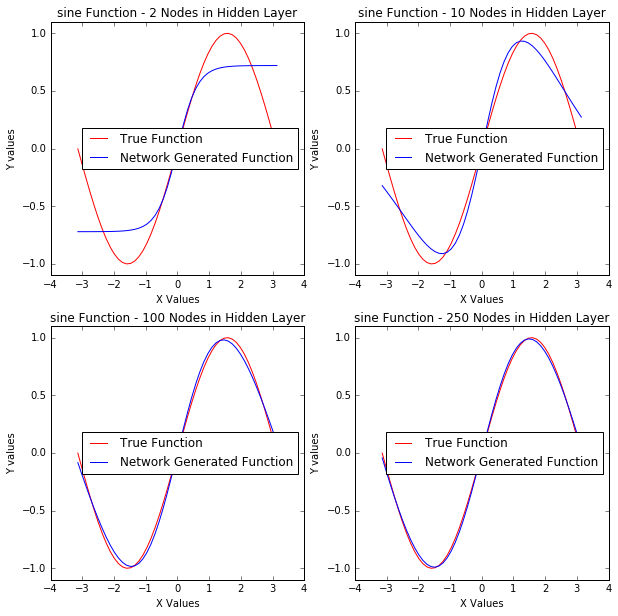

In [3]:
np.random.seed(317) # set seed for reproducibility 
# Randomly generate some fake data that follows a y = sin(x) relationship.
n_obs = 50
xs, ys = gen_trigonometric(n_obs=n_obs, func='sine')


# Fit four different sized networks, plotting the true function and 
# network generated function (e.g. it's predictions) for each network
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
hlayer_sizes = (2, 10, 100, 250)
for ax, hlayer_size in zip(axes.flatten(), hlayer_sizes):
    # Get the theano graph to iterate over, with specified `hlayer_size`
    theano_graph = get_theano_graph(hlayer_size) 
    # Iterate over the graph - the `yhats` from the final iteration will hold
    # the final predictions
    for _ in range(50000): 
        yhats = theano_graph(xs, ys)
    plot_func(xs=xs, y_true=ys, y_pred=yhats[0], n_nodes=hlayer_size, func='sine', ax=ax)

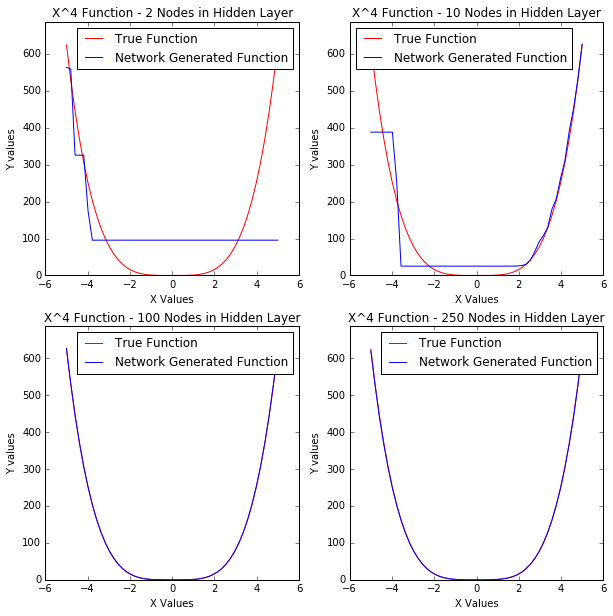

In [4]:
np.random.seed(317) # set seed for reproducibility 
# Randomly generate some fake data that follows a y = x^n relationship.
n_obs = 50
xs, ys = gen_powx(n_obs=n_obs, pow_x=4)


# Fit four different sized networks, plotting the true function and 
# network generated function (e.g. it's predictions) for each network
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
hlayer_sizes = (2, 10, 100, 250)
for ax, hlayer_size in zip(axes.flatten(), hlayer_sizes):
    # Get the theano graph to iterate over, with specified `hlayer_size`
    theano_graph = get_theano_graph(hlayer_size) 
    # Iterate over the graph - the `yhats` from the final iteration will hold
    # the final predictions
    for _ in range(50000): 
        yhats = theano_graph(xs, ys)
    plot_func(xs=xs, y_true=ys, y_pred=yhats[0], n_nodes=hlayer_size, func='X^4', ax=ax)

As we can see, our `theano` implementation is also able to learn these mathematical functions when given enough representational power (enough nodes in the hidden layer). All in all, it's pretty similar to our `numpy` implementation, but with *automatic differentiation* built in. 

Now, we'll move to coding this up using `tensorflow`, which will also allow us to avoid hard-coding the derivative calculations. 